In [114]:
import cv2
import matplotlib.pylab as plt
%matplotlib inline

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [76]:
import torchvision.models as models
from PIL import Image
from torchvision import transforms

# Load pre-trained model

In [6]:
vgg19 = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/vanna/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [66]:
model = vgg19.features

# Load images

In [279]:
style = Image.open('./vangogh.jpg')
content = Image.open('./lena.jpg')

In [280]:
def image_tensor(image):
    preprocess = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
    ])
    return preprocess(image).unsqueeze(0) 

In [281]:
style = image_tensor(style)
content = image_tensor(content)

In [282]:
def show(image):
    unloader = transforms.ToPILImage()
    image = unloader(image.squeeze(0) )
    plt.imshow(image)

## Style image

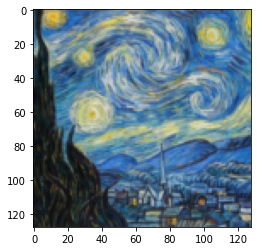

In [283]:
show(style)

## Content image

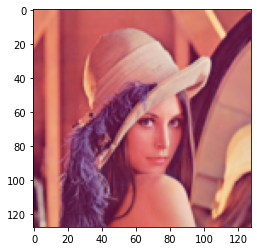

In [284]:
show(content)

# Loss functions

In [261]:
def gram_matrix(x):
    a, b, c, d = x.size()  
    features = x.view(a * b, c * d)
    G = torch.mm(features, features.t()) 
    return G.div(a * b * c * d)

In [262]:
class ContentLoss(nn.Module):
    
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [248]:
class StyleLoss(nn.Module):
    
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target).detach()

    def forward(self, x):
        G = gram_matrix(x)
        self.loss = F.mse_loss(G, self.target)
        return x

# Model

In [285]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [286]:
def make_model(cnn, content_image, style_image):
    model = nn.Sequential(Normalization())
    
    style_losses = []
    content_losses = []
    
    i = 0
    conv = False
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            conv = True
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'maxpool_{i}'        
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'batchnorm_{i}'

        model.add_module(name, layer) 

        if conv and i == 4:
            target_content = model(content_image).detach()
            content_loss = ContentLoss(target_content)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

        if conv and i < 6:
            target_style = model(style_image).detach()
            style_loss = StyleLoss(target_style)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)
        
        conv = False

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

# Run

In [287]:
input_image = content.clone()

In [291]:
def run(cnn, style_image, content_image, input_image, num_steps=500, style_weight=1e+6, content_weight=1):
    
    model, style_losses, content_losses = make_model(cnn, content_image, style_image)
    optimizer = optim.LBFGS([input_image.requires_grad_()])
#     optimizer = optim.Adam([input_image.requires_grad_()])

    print('Optimizing..')
    iters = [0]
    while iters[0] <= num_steps:

        def optim_function():
            input_image.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_image)
            style_score = 0
            content_score = 0
            
            style_score = (style_score + sum(list(map(lambda x: x.loss, style_losses)))) * style_weight
            content_score = (content_score + sum(list(map(lambda x: x.loss, content_losses)))) * content_weight

            loss = style_score + content_score
            loss.backward()

            iters[0] += 1
            if iters[0] % 50 == 0:
                print(f'iters {iters}:')
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(optim_function)

    input_image.data.clamp_(0, 1)

    return input_image

In [292]:
output = run(model, style, content, input_image)

Optimizing..
iters [50]:
Style Loss : 5.861845 Content Loss: 22.231884

iters [100]:
Style Loss : 5.367403 Content Loss: 21.645536

iters [150]:
Style Loss : 4.881195 Content Loss: 21.150476

iters [200]:
Style Loss : 4.460583 Content Loss: 20.755390

iters [250]:
Style Loss : 4.123782 Content Loss: 20.426510

iters [300]:
Style Loss : 3.859877 Content Loss: 20.183577

iters [350]:
Style Loss : 3.675589 Content Loss: 19.974327

iters [400]:
Style Loss : 3.530048 Content Loss: 19.792360

iters [450]:
Style Loss : 3.415879 Content Loss: 19.641600

iters [500]:
Style Loss : 3.311610 Content Loss: 19.519253



# Results

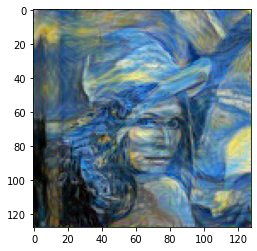

In [293]:
plt.figure()
imshow(output)

plt.ioff()
plt.show()